Method performance (lower is better):
numpy_loop: 0.060976 ms per operation
regex_extract: 0.246894 ms per operation
str_slice_find: 0.318753 ms per operation
str_partition: 0.366842 ms per operation
str_slice_split: 0.659119 ms per operation

Verifying correctness:
str_slice_find: nan
str_slice_split: RNctyIZTWmFAkcZlEJ
str_partition: RNctyIZTWmFAkcZlEJ
regex_extract: RNctyIZTWmFAkcZlEJ
numpy_loop: RNctyIZTWmFAkcZlEJ


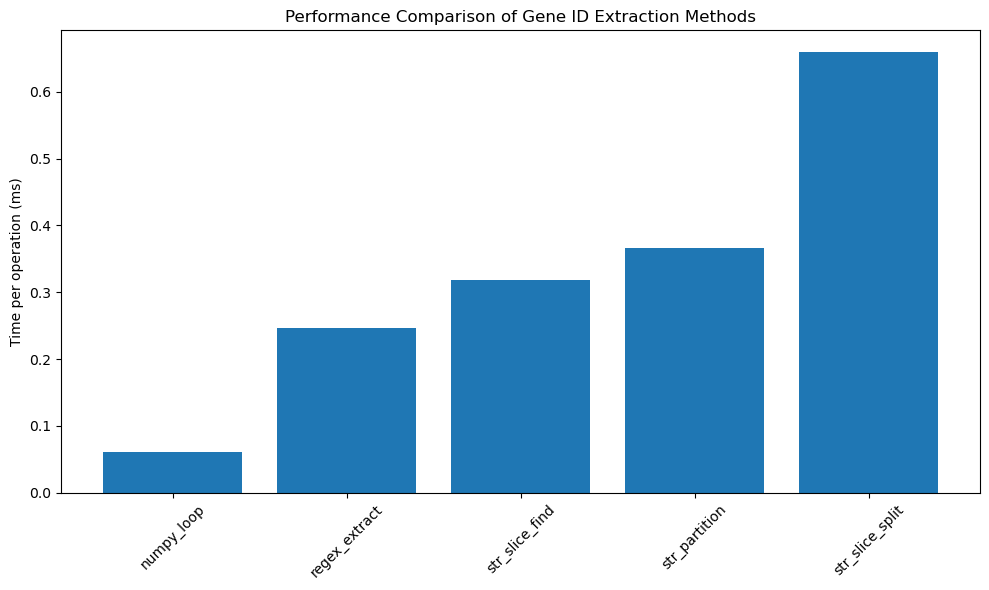

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Create a sample dataframe with 200 rows of realistic GFF attributes
def create_test_df(n_rows=200):
    attributes = []
    for i in range(n_rows):
        size = np.random.randint(3, 26)
        gene_id = ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'), size=size))
        name = f"GENE{i:05d}"
        attr = f"ID={gene_id};Name={name};biotype=protein_coding;description=Some long description with multiple words;location=chromosome{i%23+1}"
        attributes.append(attr)
    return pd.DataFrame({'attributes': attributes})

# Define the different methods to test
def method_str_slice_find(df):
    return df['attributes'].str.slice(start=3, stop=df['attributes'].str.find(';'))

def method_str_slice_split(df):
    return df['attributes'].str[3:].str.split(';').str[0]

def method_str_partition(df):
    return df['attributes'].str[3:].str.partition(';', expand=False).str[0]

def method_regex_extract(df):
    return df['attributes'].str.extract(r'^ID=([^;]+)').iloc[:, 0]

def method_numpy_loop(df):
    return pd.Series([attr[3:attr.find(';')] for attr in df['attributes'].values])

methods = {
    "str_slice_find": method_str_slice_find,
    "str_slice_split": method_str_slice_split,
    "str_partition": method_str_partition,
    "regex_extract": method_regex_extract,
    "numpy_loop": method_numpy_loop
}

# Function to run benchmarks
def run_benchmark(n_runs=1000):
    df = create_test_df()
    results = {}
    
    for name, method in methods.items():
        # Warm-up run
        try:
            _ = method(df)
        except Exception as e:
            print(f"Error in method {name}: {e}")
            continue
            
        # Timing
        start = time.time()
        for _ in range(n_runs):
            _ = method(df)
        end = time.time()
        
        results[name] = (end - start) / n_runs * 1000  # Convert to ms
    
    return results

# Run the benchmark
results = run_benchmark(n_runs=10000)

# Print results
print("Method performance (lower is better):")
for name, time_ms in sorted(results.items(), key=lambda x: x[1]):
    print(f"{name}: {time_ms:.6f} ms per operation")

# Plot results if we have any results
if results:
    plt.figure(figsize=(10, 6))
    methods_list = list(results.keys())
    times = list(results.values())
    sorted_indices = np.argsort(times)
    plt.bar(range(len(methods_list)), [times[i] for i in sorted_indices])
    plt.xticks(range(len(methods_list)), [methods_list[i] for i in sorted_indices], rotation=45)
    plt.ylabel('Time per operation (ms)')
    plt.title('Performance Comparison of Gene ID Extraction Methods')
    plt.tight_layout()

# To verify correctness
df = create_test_df()
verification_results = {}
for name, method in methods.items():
    try:
        verification_results[name] = method(df).iloc[0]
    except Exception as e:
        verification_results[name] = f"Error: {e}"

print("\nVerifying correctness:")
for name, value in verification_results.items():
    print(f"{name}: {value}")